## Introduction - Indonesian to Krama Inggil Translation using PyTorch nn.Transformer

Indonesian to Krama Inggil translation notebook using PyTorch `nn.Transformer` module.

[Dataset link](https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench).

## Setup (one time)

In [ ]:
%pip install -U portalocker
%pip install -U spacy
!python -m spacy download en_core_web_lg

## Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv

/home/dhekmass/anaconda3/envs/indonesia-to-english/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/dhekmass/anaconda3/envs/indonesia-to-english/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/dhekmass/anaconda3/envs/indonesia-to-english/lib/python3.12/sit

In [3]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## Dataset Preparation

In [4]:
SRC_LANGUAGE = 'id'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

In [5]:
token_transform[SRC_LANGUAGE] = get_tokenizer(tokenizer=None)
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_lg')

In [7]:
df = pd.read_csv(
    'input/indonesia_english_lower.csv', 
    usecols=['Indonesia', 'English'],
    sep=';',
    quoting=csv.QUOTE_NONNUMERIC
)
df.head(10)

,Indonesia,English
0,"ya, dia berhasil.","yes, he did."
1,kau telah membuatnya untukku.,you're making it for me.
2,kita perlu i.d. orang yang merespon tersebut s...,we need to i.d. the person responsible before ...
3,"mulai pendekatan, tn. cahill.",call the approach.
4,penyebab resmi kematian adalah serangan jantung.,official cod is heart attack.
5,aku harus berbicara jujur pada suamimu.,i must speak frankly to your husband.
6,mereka tak begitu saja percaya pada berita resmi.,they don't just blindly accept the official na...
7,besok dia harus sekolah.,he's got school tomorrow.
8,"jadi, itu seperti..","so, it's like... yep."
9,hai.,hi.


In [8]:
df.info()
# Hapus row yang ada missing value
df = df.dropna()
df = df.reset_index(drop=True)
# Apakah ada missing value
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644534 entries, 0 to 644533
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Indonesia  644533 non-null  object
 1   English    644393 non-null  object
dtypes: object(2)
memory usage: 9.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644393 entries, 0 to 644392
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Indonesia  644393 non-null  object
 1   English    644393 non-null  object
dtypes: object(2)
memory usage: 9.8+ MB


,Indonesia,English
0,"ya, dia berhasil.","yes, he did."
1,kau telah membuatnya untukku.,you're making it for me.
2,kita perlu i.d. orang yang merespon tersebut s...,we need to i.d. the person responsible before ...
3,"mulai pendekatan, tn. cahill.",call the approach.
4,penyebab resmi kematian adalah serangan jantung.,official cod is heart attack.
5,aku harus berbicara jujur pada suamimu.,i must speak frankly to your husband.
6,mereka tak begitu saja percaya pada berita resmi.,they don't just blindly accept the official na...
7,besok dia harus sekolah.,he's got school tomorrow.
8,"jadi, itu seperti..","so, it's like... yep."
9,hai.,hi.


In [10]:
train_csv, test_csv = train_test_split(df, test_size=0.1)

In [11]:
print(len(train_csv))

579953


In [12]:
train_csv.head()

,Indonesia,English
435832,hal ini tidak mudah.,it's not easy.
125427,"oh, bagus.","oh, that's great."
60373,aku mau ke toilet dulu.,"i have, i have to find a bathroom."
244655,aku bisa menyerahkannya ketika dia kembali.,i can get it to him when he comes back.
425772,ini tiketmu.,here is your ticket.


In [13]:
test_csv.head(10)

,Indonesia,English
570767,kamipun juga.,so are we.
412247,sulit rasanya saat aku menyadari itu.,it's hard to know when i realized it.
572262,"tuan, tolong bawa kuenya, ini bukan milik kami",mister... please take the cake away. it's not ...
631656,itu .,that.
617936,"nick tidak ada di rumah, evie.","nick's not at the house, evie."
437353,"sebuah operasi bayangan yang disebut division,...",a black ops program called division that has n...
609263,panggil aku kalau kondisinya berubah.,come for me if his condition changes.
291102,lurus ke depan.,straight ahead.
489003,"karena tuhan mengerti, sesungguhnya ia lah yan...",because god knows she's the one with the reall...
193077,jati dirimu.,who you are.


In [14]:
print(train_csv['Indonesia'].iloc[100])
print(train_csv['English'].iloc[100])

seperti yang kau lakukan.
just like you did.


In [15]:
# Custom Dataset class.
class TranslationDataset(Dataset):
    def __init__(self, csv):
        self.csv = csv
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, idx):
        return(
            self.csv['Indonesia'].iloc[idx],
            self.csv['English'].iloc[idx]
        )

In [16]:
train_dataset = TranslationDataset(train_csv)
valid_dataset = TranslationDataset(test_csv)

In [17]:
iterator = iter(train_dataset)
print(next(iterator))

('hal ini tidak mudah.', "it's not easy.")


In [18]:
# Helper function to yield list of tokens.
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices.
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab.
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Create torchtext's Vocab object.
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_dataset, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [19]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# `src` and `tgt` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # Tokenization
                                               vocab_transform[ln], # Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

## Model and Training Hyperparameters

In [20]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 192
NHEAD = 6
FFN_HID_DIM = 192
BATCH_SIZE = 192
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = 'cuda'
NUM_EPOCHS = 50

## Prepare Model

In [21]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [22]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        """
        :param max_len: Input length sequence.
        :param d_model: Embedding dimension.
        :param dropout: Dropout value (default=0.1)
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Inputs of forward function
        :param x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [23]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [25]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size: int,
        nhead: int,
        src_vocab_size: int,
        tgt_vocab_size: int,
        dim_feedforward: int = 512,
        dropout: float = 0.1
    ):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [26]:
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS, 
    NUM_DECODER_LAYERS, 
    EMB_SIZE,
    NHEAD, 
    SRC_VOCAB_SIZE, 
    TGT_VOCAB_SIZE, 
    FFN_HID_DIM
).to(DEVICE)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
print(model)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Loss function and optimizer.

In [23]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def train_epoch(model, optimizer):
    print('Training')
    model.train()
    losses = 0

    for src, tgt in tqdm(train_dataloader, total=len(list(train_dataloader))):            
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
                
        tgt_input = tgt[:, :-1]
        
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(
            src, 
            tgt_input, 
            src_mask, 
            tgt_mask,
            src_padding_mask, 
            tgt_padding_mask, 
            src_padding_mask
        )

        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def evaluate(model):
    print('Validating')
    model.eval()
    losses = 0

    for src, tgt in tqdm(val_dataloader, total=len(list(val_dataloader))):
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
        tgt_input = tgt[:, :-1]
        
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        
        logits = model(
            src, 
            tgt_input, 
            src_mask, 
            tgt_mask,
            src_padding_mask, 
            tgt_padding_mask, 
            src_padding_mask
        )

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [25]:
train_loss_list, valid_loss_list = [], []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    valid_loss = evaluate(model)
    end_time = timer()
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s \n"))

Training


  0%|          | 0/32 [00:00<?, ?it/s]

c:\Users\Dimas_Tri_Kurniawan\anaconda3\envs\terserah\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
c:\Users\Dimas_Tri_Kurniawan\anaconda3\envs\terserah\Lib\site-packages\torch\nn\functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1, Train loss: 6.517, Val loss: 6.054, Epoch time = 5.098s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 2, Train loss: 5.773, Val loss: 5.921, Epoch time = 4.455s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 3, Train loss: 5.537, Val loss: 5.643, Epoch time = 4.407s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 4, Train loss: 5.259, Val loss: 5.513, Epoch time = 4.499s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 5, Train loss: 5.091, Val loss: 5.405, Epoch time = 4.562s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 6, Train loss: 4.974, Val loss: 5.355, Epoch time = 4.611s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 7, Train loss: 4.878, Val loss: 5.305, Epoch time = 4.724s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 8, Train loss: 4.802, Val loss: 5.265, Epoch time = 4.646s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 9, Train loss: 4.732, Val loss: 5.241, Epoch time = 4.635s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 10, Train loss: 4.672, Val loss: 5.254, Epoch time = 4.538s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 11, Train loss: 4.616, Val loss: 5.220, Epoch time = 4.551s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 12, Train loss: 4.564, Val loss: 5.216, Epoch time = 4.537s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 13, Train loss: 4.516, Val loss: 5.234, Epoch time = 4.543s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 14, Train loss: 4.473, Val loss: 5.239, Epoch time = 4.656s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 15, Train loss: 4.430, Val loss: 5.223, Epoch time = 4.675s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 16, Train loss: 4.393, Val loss: 5.261, Epoch time = 4.536s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 17, Train loss: 4.353, Val loss: 5.242, Epoch time = 4.631s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 18, Train loss: 4.322, Val loss: 5.287, Epoch time = 4.736s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 19, Train loss: 4.286, Val loss: 5.257, Epoch time = 4.631s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 20, Train loss: 4.255, Val loss: 5.283, Epoch time = 4.630s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 21, Train loss: 4.220, Val loss: 5.290, Epoch time = 4.624s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 22, Train loss: 4.194, Val loss: 5.282, Epoch time = 4.621s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 23, Train loss: 4.163, Val loss: 5.295, Epoch time = 4.707s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 24, Train loss: 4.131, Val loss: 5.321, Epoch time = 4.654s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 25, Train loss: 4.101, Val loss: 5.332, Epoch time = 4.550s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 26, Train loss: 4.072, Val loss: 5.362, Epoch time = 4.516s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 27, Train loss: 4.043, Val loss: 5.367, Epoch time = 4.433s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 28, Train loss: 4.012, Val loss: 5.375, Epoch time = 4.453s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 29, Train loss: 3.988, Val loss: 5.385, Epoch time = 4.414s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 30, Train loss: 3.957, Val loss: 5.417, Epoch time = 4.406s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 31, Train loss: 3.933, Val loss: 5.462, Epoch time = 4.612s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 32, Train loss: 3.904, Val loss: 5.412, Epoch time = 4.613s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 33, Train loss: 3.868, Val loss: 5.424, Epoch time = 4.607s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 34, Train loss: 3.844, Val loss: 5.468, Epoch time = 4.682s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 35, Train loss: 3.818, Val loss: 5.466, Epoch time = 4.654s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 36, Train loss: 3.786, Val loss: 5.442, Epoch time = 4.651s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 37, Train loss: 3.754, Val loss: 5.466, Epoch time = 4.617s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 38, Train loss: 3.725, Val loss: 5.507, Epoch time = 4.697s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 39, Train loss: 3.704, Val loss: 5.508, Epoch time = 4.609s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 40, Train loss: 3.676, Val loss: 5.508, Epoch time = 4.596s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 41, Train loss: 3.637, Val loss: 5.514, Epoch time = 4.540s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 42, Train loss: 3.612, Val loss: 5.516, Epoch time = 4.623s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 43, Train loss: 3.582, Val loss: 5.530, Epoch time = 4.642s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 44, Train loss: 3.560, Val loss: 5.533, Epoch time = 4.644s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 45, Train loss: 3.519, Val loss: 5.567, Epoch time = 4.676s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 46, Train loss: 3.497, Val loss: 5.544, Epoch time = 4.864s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 47, Train loss: 3.468, Val loss: 5.562, Epoch time = 4.463s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 48, Train loss: 3.442, Val loss: 5.545, Epoch time = 4.414s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 49, Train loss: 3.412, Val loss: 5.549, Epoch time = 4.364s 

Training


  0%|          | 0/32 [00:00<?, ?it/s]

Validating


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 50, Train loss: 3.379, Val loss: 5.572, Epoch time = 4.348s 



In [26]:
os.makedirs('outputs', exist_ok=True)

## Plots

In [27]:
def save_plots(train_loss, valid_loss):
    """
    Function to save the loss plots to disk.
    """
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('outputs', 'loss.png'))
    plt.show()

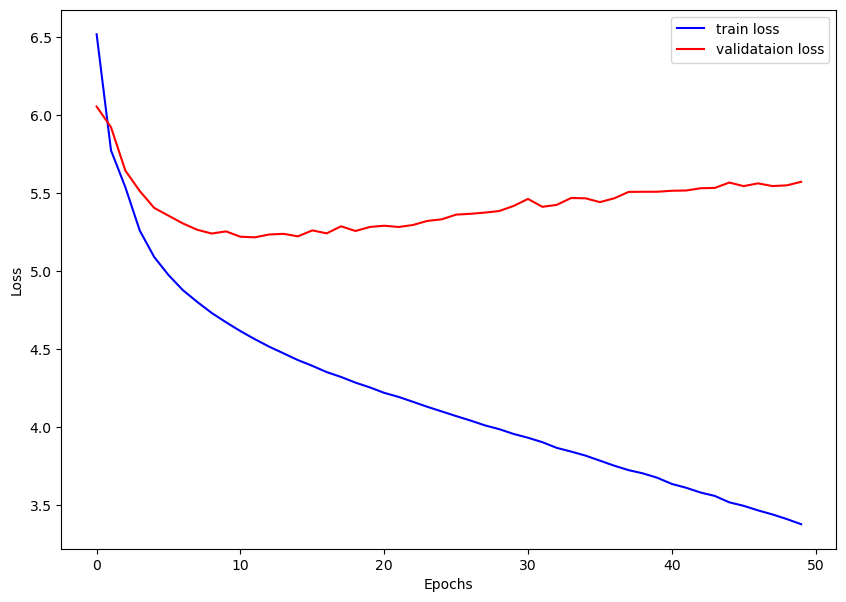

In [28]:
save_plots(train_loss_list, valid_loss_list)

## Save Model

In [29]:
torch.save(model, 'outputs/model.pth')

## Inference

In [30]:
model = torch.load('outputs/model.pth')

In [31]:
# Helper function to generate output sequence using greedy algorithm.
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        if i == 0:
            ys = ys.transpose(1, 0)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys

# Translation function. 
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
# SRC, GT pairs from the validation set.
infer_sentences = [
    ["saya suka makan.", "i like to eat."],
    ["aku tidak takut harimau.", "i am not afraid of tiger."],
    ["saya ingin tidur setelah ini.", "aku want to sleep after this."],
    ["dapatkah kamu membawa tas itu?", "can you bring that bags?."]
]

In [33]:
for sentence in infer_sentences:
    print(f"SRC: {sentence[0]}")
    print(f"GT: {sentence[1]}")
    print(f"PRED: {translate(model, sentence[0])}\n")

SRC: Saya suka makan.
GT: aku seneng mangan.
PRED:  seneng banget 

SRC: Aku tidak takut harimau.
GT: aku ora wedi harimau.
PRED:  ora ora ora ora ora ora ora ora ora ora

SRC: Saya ingin tidur setelah ini.
GT: aku pingin turu sawise iki.
PRED:  sakwisé pengen pengen ngerti carane pengen 

SRC: Kamu bisa membawa tas itu?
GT: koe iso nggawa tas kui?.
PRED:  sapa sing bisa bisa bisa numpak bisa numpak 

